# Chicken Barn Simulation
Joel Deen - 1098745
Ben Shiry - 1098077
Bradley Vanderkooy - 1101170
Marko Dimitrievski - 1089148

In [1]:
from math import pi, dist, pow
from time import sleep
from enum import Enum

import numpy as np
from skimage.draw import disk
from IPython.display import clear_output
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

from utilities.utils import underride

%matplotlib inline

In [2]:
RUN_MULTIPLE_TRIALS = True

These are helper functions and definitions in order to represent the system in the real world.

In [3]:
CENTIMETERS_PER_PIXEL = 3.0


def filter_locs(locs: np.ndarray, size: tuple[int, int]) -> np.ndarray:
    """Filters out the locs that are not in the given size."""
    return locs[np.logical_and(np.logical_and(locs[:, 0] >= 0, locs[:, 0] < size[0]),
                               np.logical_and(locs[:, 1] >= 0, locs[:, 1] < size[1]))]


def make_visible_locs(vision: int) -> np.ndarray:
    """Computes the kernel of visible cells.

    vision: int distance
    """
    return np.argwhere(np.ones((vision, vision)))

def generate_random_angle() -> float:
    """Generates a random angle that is uniform in radians."""
    return np.random.random() * 2 * pi - pi

def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)


def draw_array(array, **options) -> None:
    """Draws the cells."""
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

def get_floor_odd_number(number: int) -> int:
    """Gets the floor of the number and makes it odd.

    number: int

    returns: int
    """
    return int(np.floor(number) // 2 * 2 + 1)


For this simulation, we are characterizing the needs of the birds to the following values. While more bird needs could be attributed (like bird to bird interactions, continuity, overcrowding).

In [4]:
class ChickenNeed(Enum):
    HAPPY = 0
    THIRST = 1
    HUNGER = 2
    TEMPERATURE = 3

### Bird Agent Class
When it comes to the agent of the simulation, the agent is based off of the behaviour of the chicken. The hunger, thirst and triggers are arbitrary values that do not have any literature values associated behind this. Accurately gauging how long requires data that is not publicly available, and currently not considered within the model.
When it comes to bird temperature gradients, as seen in the temperature paper, there is a threshold of where birds are at an ideal temperature, which happens to be around 33 to 37 degrees Celsius[].
When it comes to the visibility of the birds themselves, this is based off of consulting producers on when small birds start running away from them as they walk through the barns. This number will need to be verified in later revisions.
One thing to note is the evaluate_need function, which shows the order of needs of the birds. Again, this is an assumption, but given that eating and drinking are highly correlated, and tempuature and water consumption are also highly correlated, Water will be placed first, then food then temperature.

In [5]:
class Chicken:
    BASE_HUNGER = 25
    AVG_THIRST = 75
    STD_THIRST = 10
    THIRST_TRIGGER = 50

    IDEAL_MAX_TEMP = 37
    IDEAL_MIN_TEMP = 35

    THIRST_DECAY = 5
    HUNGER_DECAY = 5

    BIRD_VISIBLE_DISTANCE = 33 # centimeters

    BIRD_VISION = int(BIRD_VISIBLE_DISTANCE // CENTIMETERS_PER_PIXEL)
    BIRD_VISION_DEVIATION = 1

    def __init__(self, loc: tuple[int, int]) -> None:
        """Creates a Chicken, which is hungary, thirsty and sensitive to temperature

        loc: tuple coordinates
        """

        self.loc = tuple(loc)
        self.thirst = int(np.random.normal(self.AVG_THIRST, self.STD_THIRST))
        self.hunger = 25
        self.temperature = np.random.randint(Chicken.IDEAL_MIN_TEMP, Chicken.IDEAL_MAX_TEMP)
        self.search_angle = generate_random_angle()
        self.need = ChickenNeed.HAPPY

        self.vision = self.BIRD_VISION

    def __evaluate_need(self) -> None:
        """ Sets the need of the chicken based on its current state.

        """
        if self.thirst < self.THIRST_TRIGGER:
            self.need = ChickenNeed.THIRST
        elif self.hunger < 0:
            self.need = ChickenNeed.HUNGER
        elif self.IDEAL_MIN_TEMP < self.temperature < self.IDEAL_MAX_TEMP:
            self.need = ChickenNeed.TEMPERATURE
        else:
            self.need = ChickenNeed.HAPPY

    def __evaluate_thirst(self, env) -> None:
        """ Sets the need of the chicken based on its current state.

        """
        thirst_addition = 0
        if self.need == ChickenNeed.THIRST:
            thirst_addition = env.waterlines.get_resource(self.loc)
        self.thirst += thirst_addition - Chicken.THIRST_DECAY
        if thirst_addition != 0:
            self.search_angle = generate_random_angle()

    def __evaluate_hunger(self, env) -> None:
        """ Gets the bird to eat and evaluate hunger"""

        hunger_addition = 0
        if self.need == ChickenNeed.HUNGER:
            hunger_addition = env.feedlines.get_resource(self.loc)
        self.hunger += hunger_addition - Chicken.HUNGER_DECAY
        if hunger_addition != 0:
            self.search_angle = generate_random_angle()

    def __evaluate_temperature(self, env) -> None:
        """Evaluates the bird's need to warm up or cool down"""
        loc_temp = env.temp_fluxuations.get_current_temp(self.loc)
        self.temperature = loc_temp

    def step(self, env) -> None:
        """Look around, move, and harvest.

        env: Barn
        """
        thirst_addition = 0
        self.__evaluate_need()
        self.loc = env.look_and_move(self.loc, self.vision, self.need, generate_random_angle())
        self.__evaluate_thirst(env)
        self.__evaluate_hunger(env)
        self.__evaluate_temperature(env)

Because birds only have a small vision, and resources are not plentiful (unlike sugarscape), there is a case where the birds needs may not be able to get the resource. For Code cleanliness, exceptions are used to reduce edge cases and readable.

In [6]:
class NeedNotFoundException(Exception):
    def __init__(self, need: ChickenNeed):
        self.need = need

    def __str__(self):
        return "Need not found: {}".format(self.need)


## The Different Scapes
Given that this is a complex being, a complex environment is also required.
Note, This barn will be modeled off of A & W Deens home farm barn (Mostly because this is the one that one of the writers is most fimilar with), so get ready for some codeblocks

Since this barn in an emagenation of multiple different sugarscapes, the tempuature sugarscape is the most like the traditional sugarscape that was presented in think complexity

In [7]:
class TempScape:
    DISTANCE_BETWEEN_HEATERS = 3  # meters
    HEAT_RADIUS = 15  # meters
    BARN_HEIGHT = 5  # meters
    HEATER_INTENSITY = 117000 / (BARN_HEIGHT**2)  # In W
    DISTANCE_BETWEEN_LINES = 4  # in meters
    NUM_LINES = 2
    X_PERMINITER_OFFSET = 2.5  # meters
    Y_PERMINITER_OFFSET = 1.5  # meters
    PIXELS_BETWEEN_HEATERS = int(DISTANCE_BETWEEN_HEATERS * 100 / CENTIMETERS_PER_PIXEL)
    HEAT_RADIUS_PIXELS = int((HEAT_RADIUS - BARN_HEIGHT) * 100 / CENTIMETERS_PER_PIXEL)
    PIXELS_BETWEEN_LINES = int(DISTANCE_BETWEEN_LINES * 100 / CENTIMETERS_PER_PIXEL)
    X_PERMINITER_OFFSET_PIXELS = int(X_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)
    Y_PERMINITER_OFFSET_PIXELS = int(Y_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)
    MINIMIUM_TEMPUATURE = 30  # degrees celcius

    def __generate_tube_heater_heatmap(self, points=False) -> None:
        """Generate the heatmap for tube heaters."""
        heat_points = []
        for i in range(self.num_rows):
            for j in range(self.size[0]):  # uses all pixels as heat sources
                x = int(self.Y_PERMINITER_OFFSET_PIXELS + j * (self.PIXELS_BETWEEN_HEATERS // 10))
                y = int(self.X_PERMINITER_OFFSET_PIXELS + i * self.PIXELS_BETWEEN_LINES)
                heat_points.append((x, y))

        if points:
            self.__draw_points(heat_points)
        else:
            self.__draw_heat_radius(heat_points)

    def __draw_heat_radius(self, points: list[tuple[int, int]]) -> None:
        """Draws the heat radius around the given points."""
        for x, y in points:
            rr, cc = disk((x, y), self.HEAT_RADIUS_PIXELS, shape=self.size)
            for i in range(len(rr)):
                if dist((x, y), (rr[i], cc[i])) != 0:
                    self.heater_array[rr[i], cc[i]] += self.HEATER_INTENSITY / (
                        (pow(dist((x, y), (rr[i], cc[i])), 2)))
                else:
                    self.heater_array[rr[i], cc[i]] += self.HEATER_INTENSITY

    def __draw_points(self, points: list[tuple[int, int]]) -> None:
        """Draws the given points."""
        for x, y in points:
            self.heater_array[x, y] = self.HEATER_INTENSITY

    def __generate_heatmap(self, points=False) -> None:
        """Generate the heatmap for ceiling heaters."""
        heat_points = []
        for i in range(self.num_rows):
            for j in range(self.num_lines):
                x = int(self.Y_PERMINITER_OFFSET_PIXELS + j * self.PIXELS_BETWEEN_HEATERS)
                y = int(self.X_PERMINITER_OFFSET_PIXELS + i * self.PIXELS_BETWEEN_LINES)
                heat_points.append((x, y))
        if points:
            self.__draw_points(heat_points)
        else:
            self.__draw_heat_radius(heat_points)
        self.heater_array += self.MINIMIUM_TEMPUATURE

    def __init__(self, size: tuple, is_tube_heater=False) -> None:
        """Initialize the TempScape object.

        size: tuple, (width, height) in pixels
        is_tube_heater: int, 0 for ceiling heaters, 1 for tube heaters
        """
        self.size = size
        num_heaters: int = size[0] // self.PIXELS_BETWEEN_HEATERS
        self.num_lines: int = int(num_heaters)
        self.num_rows: int = size[1] // self.PIXELS_BETWEEN_LINES
        self.heater_offset_y: int = self.Y_PERMINITER_OFFSET_PIXELS
        self.heater_array: np.array = np.zeros(size, dtype=np.uint8)
        if is_tube_heater:
            self.__generate_tube_heater_heatmap()
        else:
            self.__generate_heatmap()
        self.__occupancy_grid: np.array = np.zeros(size, dtype=np.uint8)

    def get_vision(self, center: tuple[int, int], vision: int) -> np.array:
        """ Find the visible heaters points for bird consumption.

        center: tuple, (x, y) in pixels
        vision: int, distance in pixels

        returns: np.array, (x, y) in pixels, where the points are waterlines visible."""
        visible_locations = filter_locs(make_visible_locs(vision) + center, self.size)
        visible_space = self.heater_array[visible_locations[:, 0], visible_locations[:, 1]]
        locations: np.array = visible_locations[np.argwhere(visible_space == 1)]
        if locations.size == 1:
            raise NeedNotFoundException
        return locations[:, 0, :]

    def get_current_temp(self, point: tuple[int, int]) -> int:
        """Get the current temperature at the given point.

        point: tuple, (x, y) in pixels

        returns: int, temperature in degrees celcius"""
        return self.heater_array[point[0], point[1]]


## WaterScape
Given a bird needs water, waterlines and their location need to be modeled in to make the model representative. Waterlines often have spacing of about 10 centimeters between each drinking spot (called nipples).
Te water radius is close to how far the bird could reach. One note is that this does lock out birds from drinking at the same time.

In [8]:
class WaterScape:
    DISTANCE_BETWEEN_NIPPLES = 0.1  # in meters
    WATER_RADIUS = 0.05  # in meters
    DISTANCE_BETWEEN_LINES = 2.5  # in meters
    NUM_LINES = 2
    X_PERMINITER_OFFSET = 1.0  # meters
    Y_PERMINITER_OFFSET = 0.03  # meters
    PIXELS_BETWEEN_LINES = int(DISTANCE_BETWEEN_LINES * 100 / CENTIMETERS_PER_PIXEL)
    WATER_RADIUS_PIXELS = int(WATER_RADIUS * 100 / CENTIMETERS_PER_PIXEL)
    PIXELS_BETWEEN_NIPPLES = int(DISTANCE_BETWEEN_NIPPLES * 100 / CENTIMETERS_PER_PIXEL)
    X_PERMINITER_OFFSET_PIXELS = int(X_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)
    Y_PERMINITER_OFFSET_PIXELS = int(Y_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)

    def __draw_water_radius(self, points: list[tuple[int, int]]) -> None:
        """Draws the water radius around the given points."""
        for x, y in points:
            rr, cc = disk((x, y), self.WATER_RADIUS_PIXELS, shape=self.size)
            self.waterline_array[rr, cc] = 1

    def __draw_points(self, points: list[tuple[int, int]]) -> None:
        """Draws the given points."""
        for x, y in points:
            self.waterline_array[x, y] = 1

    def __generate_waterlines(self, points=False) -> None:
        """Generate the waterlines."""
        waterline_points = []
        for i in range(self.num_lines):
            for j in range(self.num_nipples):
                x = int(self.Y_PERMINITER_OFFSET_PIXELS + j * self.PIXELS_BETWEEN_NIPPLES)
                y = int(self.X_PERMINITER_OFFSET_PIXELS + i * self.PIXELS_BETWEEN_LINES)
                waterline_points.append((x, y))

        if points:
            self.__draw_points(waterline_points)
        else:
            self.__draw_water_radius(waterline_points)

    def __init__(self, size: tuple) -> None:
        """Initialize the WaterScape object.

        size: tuple, (width, height) in pixels
        """
        self.size = size
        num_nipples: int = size[0] // self.PIXELS_BETWEEN_NIPPLES
        self.num_nipples: int = int(num_nipples)
        # self.waterline_offset_x = (size[0] - 1) // 2 - self.PIXELS_BETWEEN_LINES // 2
        self.num_lines: int = size[1] // self.PIXELS_BETWEEN_LINES
        self.waterline_offset_y: int = self.Y_PERMINITER_OFFSET_PIXELS
        self.waterline_array: np.array = np.zeros(size, dtype=np.uint8)
        self.__generate_waterlines()
        self.__occupancy_grid: np.array = np.zeros(size, dtype=np.uint8)

    def get_vision(self, center: tuple[int, int], vision: int) -> np.array:
        """ Find the visible waterline points for bird consumption.

        center: tuple, (x, y) in pixels
        vision: int, distance in pixels

        returns: np.array, (x, y) in pixels, where the points are waterlines visible."""
        visible_locations = filter_locs(make_visible_locs(vision) + center, self.size)
        visible_space = self.waterline_array[visible_locations[:, 0], visible_locations[:, 1]]
        locations: np.array = visible_locations[np.argwhere(visible_space == 1)]
        if locations.size == 1:
            raise NeedNotFoundException
        return locations[:, 0, :]

    def get_resource(self, point: tuple[int, int]) -> float:
        """Get the resource at the given point.

        point: tuple, (x, y) in pixels

        returns: float, resource at the given point."""
        resource = self.waterline_array[point] * 100
        return resource

## FeedScape Model
Given that the simulation has heat and water, now the simulation needs feed. The class below consists of the sugarscape model for feed-lines. These are based off of conventional flood feeders, which are about 10 centimeters in diameter, and event distribute feed during operation throughout the growing period. There are also only about 1 feedline for every 10 feet or about 3 meters in both barns.

In [9]:
import numpy as np
from skimage.draw import disk

from utilities.chicken_utils import CENTIMETERS_PER_PIXEL, filter_locs, make_visible_locs
from utilities.need_not_availible import NeedNotFoundException


class FoodScape:
    DISTANCE_BETWEEN_FEEDERS = 0.3  # in meters
    FEED_RADIUS = 0.1  # in meters
    DISTANCE_BETWEEN_LINES = 3.0  # in meters
    X_PERMINITER_OFFSET = 2.0  # meters
    Y_PERMINITER_OFFSET = 0.03  # meters
    PIXELS_BETWEEN_LINES = int(DISTANCE_BETWEEN_LINES * 100 / CENTIMETERS_PER_PIXEL)
    FEED_RADIUS_PIXELS = int(FEED_RADIUS * 100 / CENTIMETERS_PER_PIXEL)
    PIXELS_BETWEEN_TROUGHS = int(DISTANCE_BETWEEN_FEEDERS * 100 / CENTIMETERS_PER_PIXEL)
    X_PERMINITER_OFFSET_PIXELS = int(X_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)
    Y_PERMINITER_OFFSET_PIXELS = int(Y_PERMINITER_OFFSET * 100 / CENTIMETERS_PER_PIXEL)

    def __draw_feed_radius(self, points: list[tuple[int, int]]) -> None:
        """Draws the feed radius around the given points."""
        for x, y in points:
            rr, cc = disk((x, y), self.FEED_RADIUS_PIXELS, shape=self.size)
            self.feedline_array[rr, cc] = 1

    def __draw_points(self, points: list[tuple[int, int]]) -> None:
        """Draws the given points."""
        for x, y in points:
            self.feedline_array[x, y] = 1

    def __generate_feedlines(self, points=False) -> None:
        """Generate the feedlines."""
        feedline_points = []
        for i in range(self.num_lines):
            for j in range(self.num_troughs):
                x = int(self.Y_PERMINITER_OFFSET_PIXELS + j * self.PIXELS_BETWEEN_TROUGHS)
                y = int(self.X_PERMINITER_OFFSET_PIXELS + i * self.PIXELS_BETWEEN_LINES)
                feedline_points.append((x, y))

        if points:
            self.__draw_points(feedline_points)
        else:
            self.__draw_feed_radius(feedline_points)

    def __init__(self, size: tuple[int, int]) -> None:
        """Initialize the FoodScape object.

        size: tuple, (width, height) in pixels
        """
        self.size = size
        num_troughs: int = size[0] // self.PIXELS_BETWEEN_TROUGHS
        self.num_troughs: int = int(num_troughs)
        self.num_lines: int = size[1] // self.PIXELS_BETWEEN_LINES
        self.feedline_array: np.array = np.zeros(size, dtype=np.uint8)
        self.__generate_feedlines()
        self.__occupancy_grid: np.array = np.zeros(size, dtype=np.uint8)

    def get_vision(self, center: tuple[int, int], vision: int) -> np.array:
        """ Find the visible feed points for bird consumption.

        center: tuple, (x, y) in pixels
        vision: int, distance in pixels

        returns: np.array, (x, y) in pixels, where the points are feedlines visible."""
        visible_locations = filter_locs(make_visible_locs(vision) + center, self.size)
        visible_space = self.feedline_array[visible_locations[:, 0], visible_locations[:, 1]]
        locations: np.array = visible_locations[np.argwhere(visible_space == 1)]
        if locations.size == 1:
            raise NeedNotFoundException
        return locations[:, 0, :]

    def get_resource(self, point: tuple[int, int]) -> float:
        """Get the resource at the given point.

        point: tuple, (x, y) in pixels

        returns: float, resource at the given point."""
        resource = self.feedline_array[point] * 100
        return resource


# The barn itsself
Now that the three needs of the birds are addressed, all three of them can be merged together in order to create a very basic chicken barn, along with the ways of measuring it.

### Measuring Uniformity
Upon research, there was no clear way to measure uniformity within a sugarscape or agent based models, and so the group had to come up with something, and so to keep it simple. The model counts the number of bird around it, and take the standard deviation of all the measurements. The thought of that an ideal distrobution would have a low standard deviation

In [10]:
class Barn:

    def __create_chickens(self, num_birds: int) -> None:
        """Creates a list of chickens.

        size: tuple of the size of the barn
        """

        locs = make_locs(self.barn_size[0], self.barn_size[1])
        np.random.shuffle(locs)
        for i in range(num_birds):
            self.chickens.append(Chicken(locs[i]))

        self.occupacy = set(chicken.loc for chicken in self.chickens)

    def temp(self, loc) -> float:
        """Returns the temperature increase per second at loc, assuming the mass is 174 g (Average mass of a chicken)
        """
        return self.temp_fluxuations.heater_array[loc] / 174

    def __init__(self, size: tuple, num_chickens=500, tube_heaters=False) -> None:
        self.waterlines = WaterScape(size)
        self.feedlines = FoodScape(size)
        self.temp_fluxuations = TempScape(size, tube_heaters)
        self.barn_size = size
        self.occupacy = set()
        self.chickens = []
        self.__create_chickens(num_chickens)
        self.points = None

    def look_and_move(self, loc: tuple[int, int], vision: int, need: ChickenNeed, wander_angle: float) -> tuple[
        int, int]:
        """Look around and move to a new location.

        loc: tuple of coordinates
        vision: int distance
        need: ChickenNeed What the chicken needs in order to be happy
        wander_angle: float of the angle in radians that it will wander

        returns
        ---
        tuple[int, int]: 2d point of the location of the bird

        """
        locs = None
        try:
            if need == ChickenNeed.HAPPY:
                # No need to move the bird as it is already good.
                return loc
            if need == ChickenNeed.THIRST:
                locs = self.waterlines.get_vision(loc, vision)
            elif need == ChickenNeed.HUNGER:
                locs = self.feedlines.get_vision(loc, vision)
            elif need == ChickenNeed.TEMPERATURE:
                locs = self.temp_fluxuations.get_vision(loc, vision)
        except NeedNotFoundException:
            return self.wander(loc, vision, wander_angle)

        locs = [tuple(loc) for loc in locs]

        empty_locs = [loc for loc in locs if loc not in self.occupacy]

        if len(empty_locs) == 0:
            return self.wander(loc, vision, wander_angle)

        return empty_locs[0]

    def wander(self, loc: tuple[int, int], vision: int, wander_angle: float) -> tuple[int, int]:
        """ Gets the bird to look around the barn for the required resource.
        """
        wander_samples = 20

        empty_locs = []

        wander_vision = vision

        while len(empty_locs) == 0:
            search_angles = (np.random.random(wander_samples) * pi / 2) - pi / 4 + wander_angle
            x = (wander_vision * np.cos(search_angles)).astype(np.int16)
            y = (wander_vision * np.sin(search_angles)).astype(np.int16)
            np_locs = filter_locs(np.array([x, y]).T + loc, self.barn_size)
            locs = [tuple(loc) for loc in np_locs]

            empty_locs = [loc for loc in locs if loc not in self.occupacy]
            wander_vision -= 1
            if wander_vision <= 0:
                break

        if len(empty_locs) == 0:
            return loc
        else:
            return empty_locs[0]

    def step(self) -> float:
        """Simulates one time step."""
        random_order = np.random.permutation(self.chickens)
        for chicken in random_order:
            self.occupacy.remove(chicken.loc)
            chicken.step(self)
            self.occupacy.add(chicken.loc)
        return self.measure_uniformity()


    def get_coords(self) -> tuple[np.ndarray, np.ndarray]:
        """Gets the coordinates of the chickens."""

        chickens = self.chickens
        rows, cols = np.transpose([chicken.loc for chicken in chickens])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

    def draw(self) -> None:
        """ Draws the Top-Down view of the barn
        """
        self.draw_without_birds()

        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='white')[0]

    def draw_without_birds(self) -> None:
        draw_array(self.temp_fluxuations.heater_array - self.temp_fluxuations.MINIMIUM_TEMPUATURE, cmap='viridis', origin='upper')
        draw_array(self.waterlines.waterline_array, cmap='viridis', origin='upper')
        draw_array(self.feedlines.feedline_array, cmap='viridis', origin='upper')

    def animate(self, interval=0.1, frames=10, step=None) -> list[float]:
        """ Animates a Top-Down view of the barn environment

            frames: number of frames to draw
            interval: time between frames in seconds
        """
        results = []
        if step == None:
            step = self.step

        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                if interval:
                    sleep(interval)
                results.append(step())
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass
        return results

    def run(self, frames=100, step=None):
        results = []
        if step == None:
            step = self.step
        try:
            for i in range(frames-1):
                results.append(step())
        except KeyboardInterrupt:
            pass
        return results

    def measure_uniformity(self) -> float:
        """ Measures the uniformity of the barn.

        This is a badly written function, we don't talk about it
        """
        num_birds = len(self.chickens)
        kernel_size = get_floor_odd_number(np.sqrt(num_birds))
        kernel = np.ones((kernel_size, kernel_size))
        kernel[kernel_size // 2, kernel_size // 2] = 0
        bird_locs = np.array(list(map(np.array, self.occupacy)))
        occupancy_array = np.zeros(self.barn_size)
        occupancy_array[bird_locs[:, 0], bird_locs[:, 1]] = 1
        count_result = convolve2d(occupancy_array, kernel, mode='same')
        filtered_result = count_result[bird_locs[:, 0], bird_locs[:, 1]]
        return np.std(filtered_result)

## Hyperparameters
These hyperparameters are the result of distributions within a given chicken barn distribution. It can be calculated that approximately 2000 birds are situated in the barn


In [11]:
NUM_BIRDS = 2000
SIM_SIZE = 300, 300  # About 30 feet by 30 feet

As seen in the plot below, there are three lines where there are big squares. These are feedlines, and the small yellow dots are waterlines. When it comes to the lighter purple areas, are areas in which there is a large amount of heat applied to the barn its self.

### Tube Heater Environments
As seen in the heat distribution below, Tube heaters are consistent along an edge until a point. Below shows the setup for the barn environment.

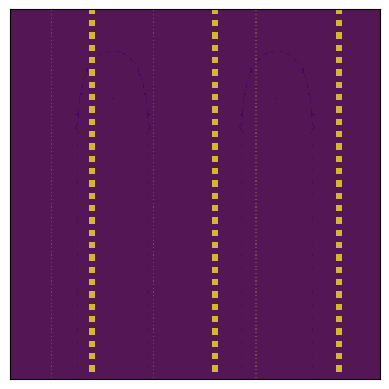

In [12]:
barn = Barn(SIM_SIZE, NUM_BIRDS, tube_heaters=True)
barn.draw_without_birds()

Drawing the barn with the points that are birds, it can be seen that there is a random distribution of birds within the "barn" its self

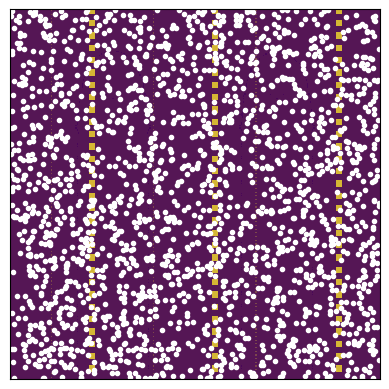

In [13]:
barn.draw()

Stepping the simulation, you can see that soe of the points have moved in various directions as a result of search function along with moving towarsd the water and feed lines within the barn

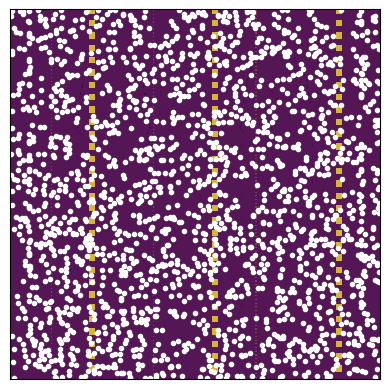

In [14]:
barn.step()
barn.draw()

Running an animation of the model(This may take a minute or two depending on the processor and python version)
It can be seen that these birds migrate towards the feed and waterlines and stay there. Talking with Bill Deen about these results, this is not what is occurs with birds as they grow. This difference could be due to the lack of consideration of heat being emitted by other birds, and birds desire to space themselves out from other birds. Something to take a look at would be to see how simple heat preservation behaviours effects this result. This lack of a result could also be due to lack of consideration for bedding conditions around the feed and waterlines as well

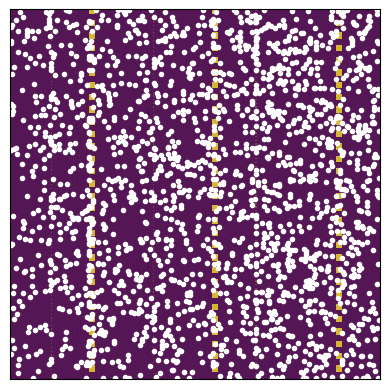

In [15]:
results = barn.animate(frames=100, interval=0.1)

Plotting the standard deviation over time, it can be seen that there is often a low deviation at the beginning, and it slowly rises as time goes on. This is showing of a lowering of uniformity within the system.

Text(0.5, 1.0, 'Bird standard distribution over 100 iterations')

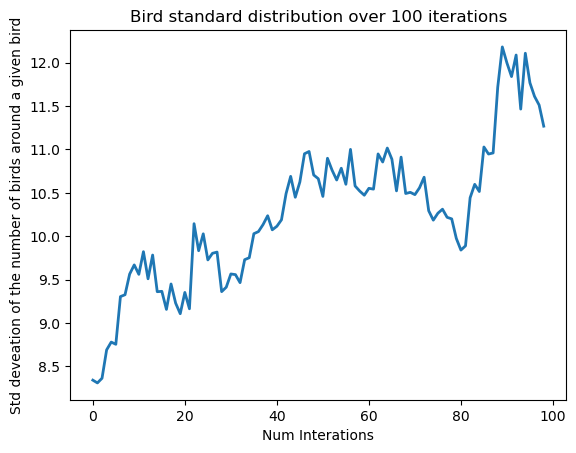

In [16]:
plt.plot(np.arange(len(results)), np.array(results))
plt.xlabel('Num Interations')
plt.ylabel('Std deveation of the number of birds around a given bird')
plt.title('Bird standard distribution over 100 iterations')

Note, Run this cell if interested in taking a look at the noise within the model multiple times, it can be seen that these results are fairly noisy, but all follow a similar trend.

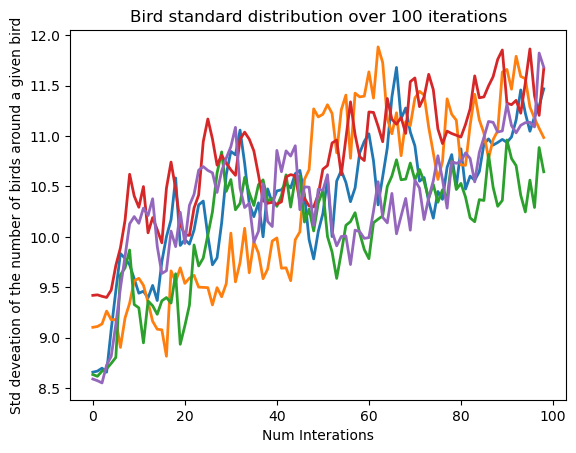

In [17]:
if RUN_MULTIPLE_TRIALS:
    for i in range(5):
        iter_barn = Barn(SIM_SIZE, NUM_BIRDS, tube_heaters=True)
        results = iter_barn.run(frames=100)
        plt.plot(np.arange(len(results)), np.array(results))
        plt.xlabel('Num Interations')
        plt.ylabel('Std deveation of the number of birds around a given bird')
        plt.title('Bird standard distribution over 100 iterations')

### Circular Heaters

Trying the circular heaters in the ceiling instead of the tube heaters, it is found that there is less area for the birds to explore compared to the tube heaters.

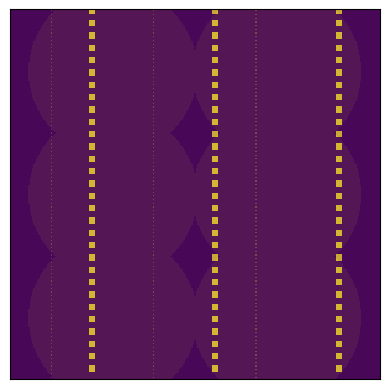

In [18]:
other_barn = Barn(SIM_SIZE, NUM_BIRDS, tube_heaters=False)
other_barn.draw_without_birds()

Running the simulation over a few iterations results in a similar result

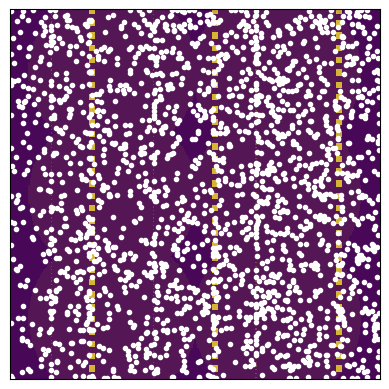

In [19]:
other_results = other_barn.animate(frames=100, interval=0.1)

This can be seen in the figure below that it has a similar shape to the tube heater distribution.

Text(0.5, 1.0, 'Bird standard distribution over 100 iterations')

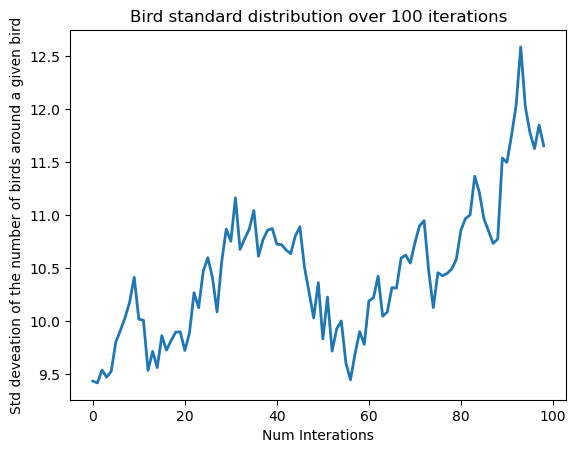

In [20]:
plt.plot(np.arange(len(other_results)), np.array(other_results))
plt.xlabel('Num Interations')
plt.ylabel('Std deveation of the number of birds around a given bird')
plt.title('Bird standard distribution over 100 iterations')


Running the simulation multiple times reinforces this observation.

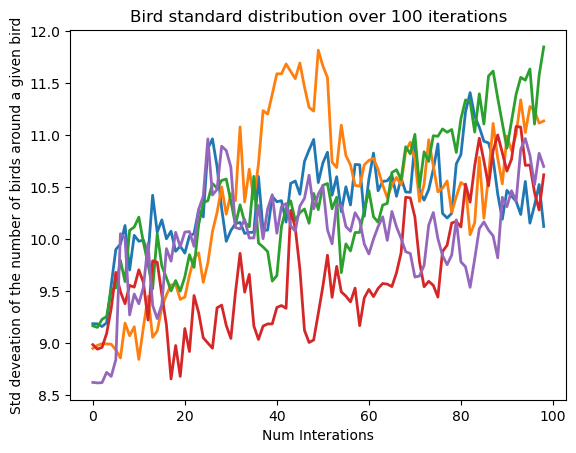

In [21]:
if RUN_MULTIPLE_TRIALS:
    for i in range(5):
        iter_barn = Barn(SIM_SIZE, NUM_BIRDS, tube_heaters=False)
        results = iter_barn.run(frames=100)
        plt.plot(np.arange(len(results)), np.array(results))
        plt.xlabel('Num Interations')
        plt.ylabel('Std deveation of the number of birds around a given bird')
        plt.title('Bird standard distribution over 100 iterations')